# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from tabulate import tabulate
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from IPython.display import Image, display
from IPython.core.display import HTML
from dotenv import load_dotenv
import os

load_dotenv()
SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
SPOTIFY_CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

# Phase 1 : Reading Data

In [3]:
track_data=pd.read_csv("./data/data.csv")
genre_data=pd.read_csv("./data/data_by_genres.csv")
year_data=pd.read_csv("./data/data_by_year.csv")
artist_data=pd.read_csv("./data/data_by_artist.csv")
artist_plus_genre=pd.read_csv("./data/data_w_genres.csv")

In [3]:
track_data.head(2)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936


In [4]:
genre_data.head(2)

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.3616,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.1310,-16.854000,0.076817,120.285667,0.221750,52.500000,5


In [5]:
year_data.head(2)

,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.886896,0.418597,260537.166667,0.231815,0.344878,0.20571,-17.048667,0.073662,101.531493,0.379327,0.653333,2
1,1,1922,0.938592,0.482042,165469.746479,0.237815,0.434195,0.24072,-19.275282,0.116655,100.884521,0.535549,0.140845,10


In [6]:
artist_data.head(2)

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690,0.176212,103.044154,0.268865,30.576923,5


In [7]:
artist_plus_genre.sample(2)

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
28641,[],稲毛 謙介(TEMPEST STUDIO),0.001810,0.588000,96149.0,0.978000,0.011200,0.36300,-4.884000,0.031100,125.818000,0.637000,54.0,1,1,1
12778,"['album rock', 'birmingham metal', 'classic ro...",Judas Priest,0.035421,0.380216,262622.0,0.831383,0.049023,0.30995,-5.985217,0.079207,129.332125,0.350872,37.4,9,1,240


In [4]:
# Removing redudndant feature
track_data=track_data.drop('release_date',axis=1)

--------
**About the datasets**

1- **track_data**
- List of various tracks with their associated features and metadata.

2- **genre_data**
- List of various musical genres with features associated to these.

3- **year_data**
- List of years and musical features associated to them, handy to see the evolution of the metrics across time.

4- **artist_data**
- List of artists and composers with musical features.

5- **artist_plus_genre**
- List of artists and the genres they associate with.
-------

** NOTE **
Even though the artists and genre values look like lists, they are in fact strings, let's deal with that:

1- Convert the strings to actual lists.

2- Add the genres to the tracks dataset.

In [5]:
def cleaner_v1(value):
  try:
    lst=ast.literal_eval(value)
    if isinstance(lst,list):
      return lst
    else:
      return [lst]
  except (ValueError,SyntaxError):
    # In anticipation of names containing apostrophes
    lst=value.strip('[]')
    return [item.strip().strip("'\"") for item in lst.split(',') if item.split()]
  

def cleaner_v2(value):
  try:
    lst=ast.literal_eval(value)
    if isinstance(lst,list):
      lst=[x.replace(' ','_') for x in lst]
      return lst
    else:
      return [lst.replace(' ','_')]
  except (ValueError,SyntaxError):
    # In anticipation of names containing apostrophes
    lst=value.strip('[]')
    return [item.strip().strip("'\"").replace(' ','_')  for item in lst.split(',') if item.split()]

In [6]:
track_data['artists_v1']=track_data['artists'].apply(cleaner_v1)
track_data['artists_v2']=track_data['artists'].apply(cleaner_v2)
artist_plus_genre['genres_v1']=artist_plus_genre['genres'].apply(cleaner_v1)
artist_plus_genre['genres_v2']=artist_plus_genre['genres'].apply(cleaner_v2)

- **Lets create a map between the artists and their genres**

In [7]:
artists_genre_mapping_v1={k:v for k,v in zip(artist_plus_genre['artists'],artist_plus_genre['genres_v1'])}
artists_genre_mapping_v2={k:v for k,v in zip(artist_plus_genre['artists'],artist_plus_genre['genres_v2'])}

In [8]:
def get_genre(artists,mapping):
    '''
    Function that returns the aggregate of the genres asscoiated to a list of artists.
    '''
    genres=[]
    if not isinstance(artists,list):
        artists=[artists]
    for artist in artists:
        if artist in mapping.keys():
            genres+=mapping[artist]
    return list(set(genres))

In [9]:
track_data['genres_v1']=track_data['artists_v1'].apply(lambda x:get_genre(x,artists_genre_mapping_v1))
track_data['genres_v2']=track_data['artists_v1'].apply(lambda x:get_genre(x,artists_genre_mapping_v2))

**Our final Tracks data looks like this**
- **Important note**
Some tracks appear to be duplicates, they mostly are variations of the same song (Folkloric songs, Holidays music ... etc ), or songs from different artists bearing the same title. We will leave them as they are.

In [14]:
track_data.sample(10)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,artists_v1,artists_v2,genres_v1,genres_v2
157303,0.2840,1953,0.971,['Helen Gallagher'],0.358,143747,0.120,0,2OriQwPHfonIjxcAAuHcnE,0.000000,5,0.6180,-11.447,1,The World Is Beautiful Today,0,0.0330,105.582,[Helen Gallagher],[Helen_Gallagher],[],[]
38961,0.2570,1928,0.965,"['Frédéric Chopin', 'Vladimir Horowitz']",0.296,157027,0.190,0,1umL3VcIwjmmIurYFwk4xZ,0.899000,10,0.1260,-17.158,0,"Étude in C Minor, Op. 10, No. 12 ""Revolutionary""",1,0.0310,108.282,"[Frédéric Chopin, Vladimir Horowitz]","[Frédéric_Chopin, Vladimir_Horowitz]","[polish classical, classical, early romantic e...","[classical, classical_piano, classical_perform..."
77016,0.6750,1941,0.994,['Ila Ghosh'],0.459,165240,0.128,0,7FJpVWJoRhfOTcBKzI7h8T,0.680000,4,0.2560,-19.923,1,Apna Jeevan Darpan Nyara,0,0.0649,91.745,[Ila Ghosh],[Ila_Ghosh],[],[]
10008,0.9130,1972,0.221,['The Doobie Brothers'],0.645,227267,0.598,0,7Ar4G7Ci11gpt6sfH9Cgz5,0.000004,1,0.0721,-13.180,0,Listen to the Music,76,0.0335,105.929,[The Doobie Brothers],[The_Doobie_Brothers],"[heartland rock, hard rock, art rock, folk roc...","[yacht_rock, album_rock, folk_rock, heartland_..."
68577,0.0722,1987,0.666,['The Pretenders'],0.337,267800,0.143,0,0SDXfgqRSPrY6QRn9wU9C4,0.000251,0,0.2510,-16.452,1,Have Yourself A Merry Little Christmas,41,0.0283,83.201,[The Pretenders],[The_Pretenders],[],[]
63977,0.8000,1964,0.455,['Pat Boone'],0.311,144827,0.847,0,5GWHzvmJIrGQ5F4m7MUtfN,0.000000,10,0.0791,-4.944,1,Tutti Frutti,28,0.1510,187.678,[Pat Boone],[Pat_Boone],"[lounge, rock-and-roll, brill building pop, ea...","[lounge, adult_standards, rock-and-roll, brill..."
71166,0.4570,2000,0.712,"['Henri Salvador', 'Lisa Ekdahl']",0.615,248307,0.459,0,4EtULbS8K8zZ3apaEX36oI,0.002080,1,0.0887,-10.156,1,All I Really Want Is Love,52,0.0313,142.025,"[Henri Salvador, Lisa Ekdahl]","[Henri_Salvador, Lisa_Ekdahl]","[chanson, classic swedish pop, french pop, swe...","[swedish_pop, french_pop, chanson, classic_swe..."
131654,0.7720,1974,0.622,['Randy Newman'],0.642,189333,0.607,0,1Y4YTkmEPJradjnnyTD5TR,0.000844,9,0.1200,-11.684,1,Naked Man - Remastered,25,0.0375,126.710,[Randy Newman],[Randy_Newman],"[singer-songwriter, disney, movie tunes]","[singer-songwriter, disney, movie_tunes]"
17399,0.6820,2008,0.184,"['Angel Y Khriz', 'Gocho ""El Lápiz De Platino""...",0.878,202867,0.894,0,2Jz1X6ZB0gkkCVgmeVGVGp,0.000000,6,0.1050,-5.834,1,Na De Na,69,0.1230,119.927,"[Angel Y Khriz, Gocho ""El Lápiz De Platino"", J...","[Angel_Y_Khriz, Gocho_""El_Lápiz_De_Platino"", J...","[trap latino, latin hip hop, reggaeton, latin ...","[latin_pop, latin_hip_hop, trap_latino, reggae..."
108607,0.6730,2019,0.218,['girl in red'],0.689,186643,0.662,1,5MAjVARSIDzwz8jFG36hFu,0.000033,7,0.3950,-6.732,1,dead girl in the pool.,68,0.0612,129.957,[girl in red],[girl_in_red],"[bedroom pop, indie pop, bubblegrunge, norwegi...","[bedroom_pop, indie_pop, bubblegrunge, norwegi..."


# Phase 2 : Exploratory Data Analysis

* **We explore now the correlation levels between our numerical features**

<Axes: >

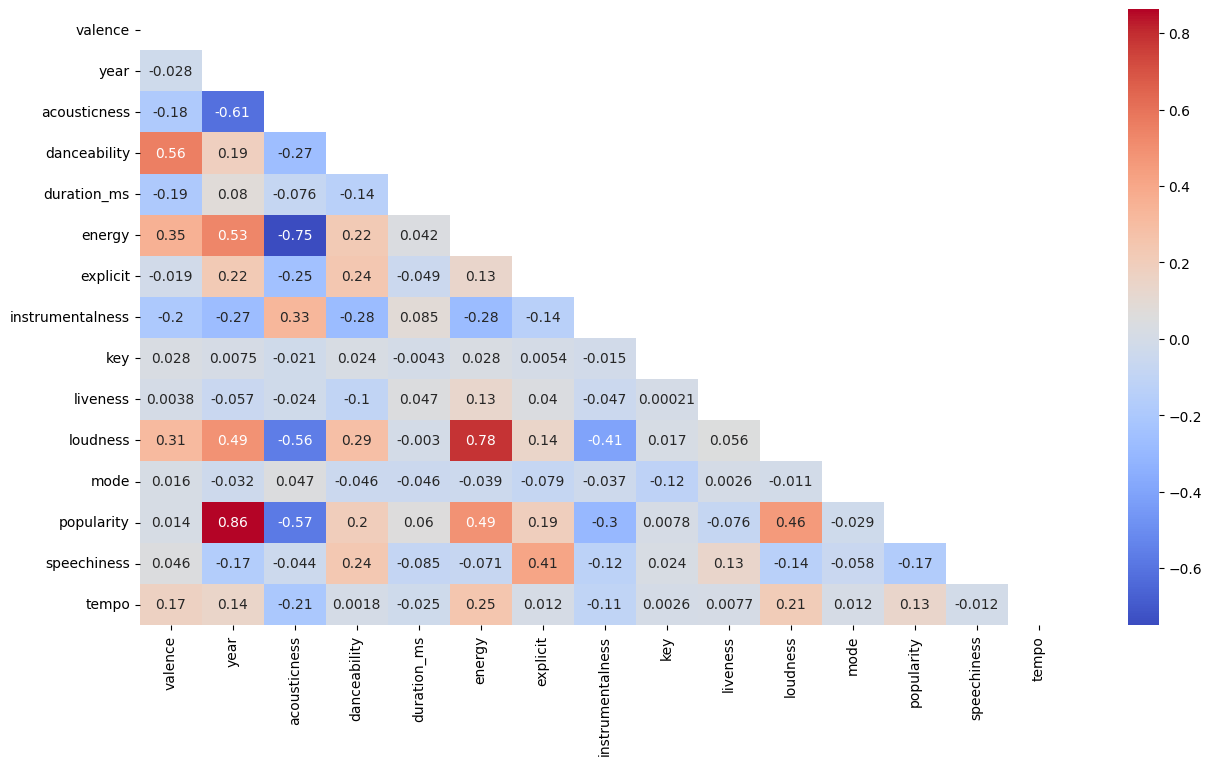

In [15]:
# Correlation heatmap
corr=track_data.corr(numeric_only=True)
plt.figure(figsize=(15,8))
matrix = np.triu(corr)
sns.heatmap(corr,annot=True,cmap='coolwarm',mask=matrix)

- **Notice the strong correlation between popularity and year**, which is understandable given that songs are more likely to peak in popularity when they drop new.

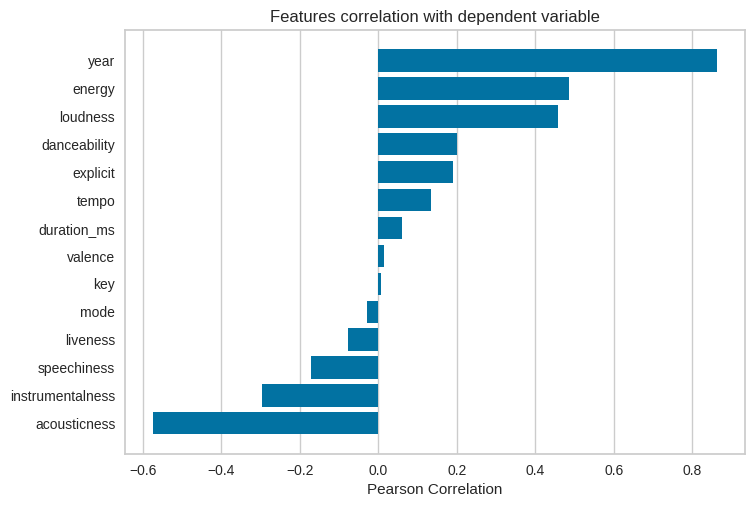

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [16]:
from yellowbrick.target import FeatureCorrelation

features=['valence', 'acousticness',  'danceability',
       'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode',
       'speechiness', 'tempo','year']

X,y=track_data[features],track_data['popularity']

visualizer = FeatureCorrelation(labels=features,sort=True)
visualizer.fit(X, y)
visualizer.show()

- **Let's see the statistical distribution of the song's characteristic featuers**

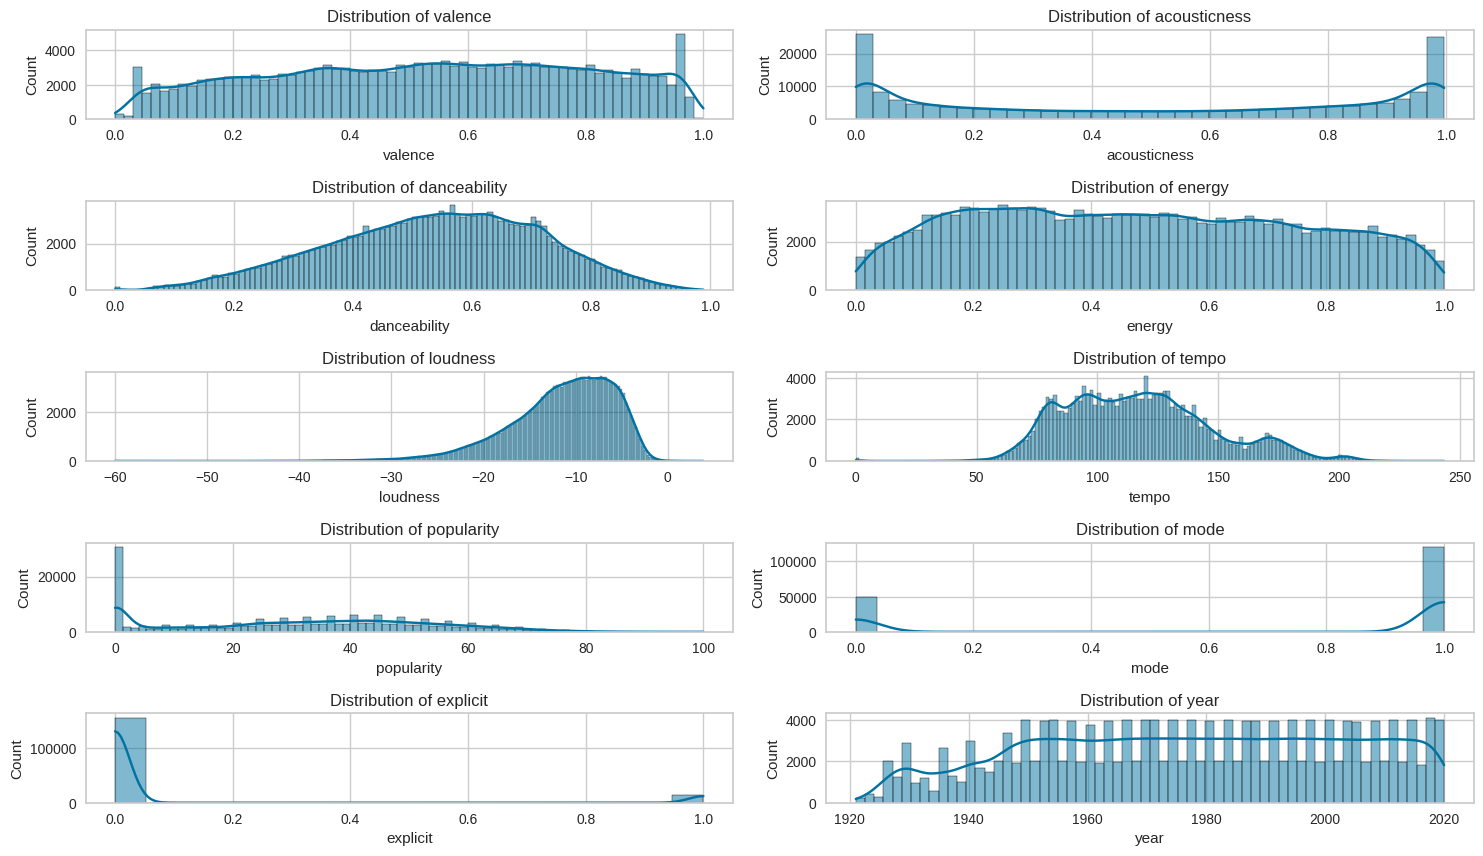

In [17]:
caract_features=['valence', 'acousticness',  'danceability', 'energy','loudness','tempo','popularity','mode','explicit','year']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(caract_features):
    plt.subplot(6, 2, i+1)
    sns.histplot(track_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

- Notice that some features such as Valence and Energy exhibit a uniform distribution across the range. These feature would have less of an impact by themselves when it comes to clustering at a later phase.
- Other features such as accousticness and mode have a distinct bimodal distribution, which makes it relevant when it comes to seperating the songs into classes.
- That being said, all those put toghether bring the necessary granularity to cluster songs, we will take some measures to optimise that.

### Binning features

- Let's investigate the popularity on musical genres over time.
- We can achieve that by counting the number of times they appear each year.

In [18]:
year_counts = track_data['year'].value_counts().sort_index()

fig = go.Figure(data=[
    go.Bar(
        x=year_counts.index,
        y=year_counts.values,
        marker_line_color='rgb(8,48,107)',
        marker_line_width=1.5,
        opacity=0.6
    )
])

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Count',
    xaxis=dict(tickangle=90)
)

fig.show()

- From the above histrogram, we notice an even distribution of songs starting from 1945
We will explore now the popularity of genres by year

**Now, Let's see how the musical genres popularity evolve over time**

To achieve that, we explore the top 5 popular genres per year, see how much time it takes for a new one to take the top spot

In [19]:
# We keep the 5 top popular songs per year
top_songs = track_data.sort_values(['year', 'popularity'], ascending=[True, False]).groupby('year').head(5)

In [20]:
# Genre counts per year
genre_counts = top_songs.explode('genres_v1').groupby(['year', 'genres_v1']).size().unstack(fill_value=0)

In [21]:
# Top 5 genres per year
top5_genres_by_year = genre_counts.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)

In [22]:
# The most popular genre per year
top_genre_by_year = genre_counts.idxmax(axis=1)

In [23]:
# Detects when a new top genre appears
new_top_genres = top_genre_by_year[top_genre_by_year.shift() != top_genre_by_year]
# Calculate the time for a new genre to take the top place
time_to_top = new_top_genres.index.to_series().diff()

In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=new_top_genres.index,
    y=time_to_top,
    mode='lines+markers',
    name='Time to Top',
    text=new_top_genres,
    hovertemplate='Year: %{x}<br>Time to Top: %{y:.1f} years<br>New Top Genre: %{text}<extra></extra>'
))

fig.update_layout(
    title='Time for a New Genre to Reach the Top Spot',
    xaxis_title='Year',
    yaxis_title='Years to Reach Top',
    hovermode='closest'
)

fig.show()

- Now lets explore how popular genres evolve over across the years

In [25]:
N = 10
top_genres_overall = genre_counts.sum().nlargest(N).index
custom_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]
fig = go.Figure()

for i, genre in enumerate(top_genres_overall):
    fig.add_trace(go.Scatter(
        x=genre_counts.index,
        y=genre_counts[genre],
        name=genre,
        line=dict(color=custom_colors[i]),
        hovertemplate='Year: %{x}<br>Count: %{y}<br>Genre: ' + genre + '<extra></extra>'
    ))

fig.update_layout(
    title='Evolution of Popular Genres Over the Years',
    xaxis_title='Year',
    yaxis_title='Number of Songs in Top 5',
    hovermode='closest',
    legend_title='Genres'
)

fig.show()

- Notice how the popular genres change every decade, that would be our first bucketing step, let's create the decade feature

In [26]:
track_data['decade']=track_data['year'].apply(lambda x:x//10*10)

- Let's explore how the features evolve.

In [27]:
#trends of various sound features (acousticness, danceability, energy, instrumentalness, liveness, valence) over decades

year_data['decade']=year_data['year'].apply(lambda x:x//10*10)

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


features=['acousticness','danceability','energy','instrumentalness','liveness','valence']


fig = go.Figure()

for feature in features:
    fig.add_trace(go.Scatter(x=year_data['decade'], y=year_data[feature], mode='lines', name=feature))


fig.update_layout(
    title='Features Over Decades',
    xaxis_title='Decade',
    yaxis_title='Value',
    legend_title='Features',
    hovermode='x unified'
)


fig.show()

- We notice an evolution of certain featuers over decades, like the descending trend of acousticness over time due to the introduction of electronics and computers into music production.

- Other featuers such as danceability and energy accused an increase, probably due to the apparition of new musical genres such as pop and EDM, the fast paces modern lifestyle also have a major contribution, as well as the vogue nature of night lifestyle in recent times.

In [29]:
#trend of loudness over decades

fig=go.Figure()

fig.add_trace(go.Scatter(x=year_data['decade'],y=year_data['loudness'],mode='lines',name='loudness'))

fig.update_layout(
    title='Loudness Over Decades',
    xaxis_title='Decade',
    yaxis_title='Value',
    legend_title='Features',
    hovermode='x unified'
)

fig.show()

In [30]:
#top 10 genres based on popularity and plot the trends of various sound features grouped bar chart

top_10_genres=genre_data.sort_values(by='popularity',ascending=False).head(10)

features=['acousticness','danceability','energy','instrumentalness','liveness','valence']

fig=make_subplots(rows=1,cols=6,subplot_titles=tuple([feature for feature in features]))

for feature in features:
  fig.add_trace(go.Bar(x=top_10_genres['genres'],y=top_10_genres[feature],name=feature),row=1,col=features.index(feature)+1)

fig.update_layout(
    title='Top 10 Genres',
    xaxis_title='Genre',
    yaxis_title='Value',
    legend_title='Features',
    hovermode='x unified'
)

fig.show()



In [31]:
top_10_genres

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
237,1,basshall,0.213167,0.81800,169799.166667,0.630167,0.000020,0.081067,-6.627833,0.134833,115.092500,0.588667,80.666667,2
2755,1,trap venezolano,0.044600,0.87700,231848.000000,0.777000,0.000035,0.086300,-4.246000,0.117000,102.020000,0.706000,80.000000,1
2778,0,turkish edm,0.008290,0.69800,186700.000000,0.719000,0.000004,0.326000,-4.923000,0.045500,120.062000,0.364000,80.000000,0
2533,1,south african house,0.043833,0.84700,311854.333333,0.562333,0.130339,0.075133,-7.719000,0.050733,123.676333,0.834333,80.000000,1
536,0,chinese electropop,0.002570,0.66000,217088.000000,0.787000,0.000000,0.323000,-4.592000,0.032000,142.018000,0.199000,78.500000,1
46,0,alberta hip hop,0.330000,0.88500,144000.000000,0.685000,0.000000,0.148000,-6.429000,0.062700,99.954000,0.937000,78.500000,11
37,0,afroswing,0.318450,0.71175,179995.375000,0.580187,0.000258,0.189950,-7.016687,0.195563,83.250125,0.676625,77.312500,11
31,0,afro soul,0.006270,0.76600,202627.000000,0.873000,0.000000,0.076400,-6.381000,0.143000,126.988000,0.743000,77.000000,11
1239,1,guaracha,0.009030,0.74500,189818.000000,0.972000,0.465000,0.297000,-3.506000,0.077400,128.031000,0.556000,77.000000,7
1381,1,indie triste,0.946000,0.83000,207400.000000,0.159000,0.000020,0.362000,-14.461000,0.038300,104.950000,0.189000,77.000000,1


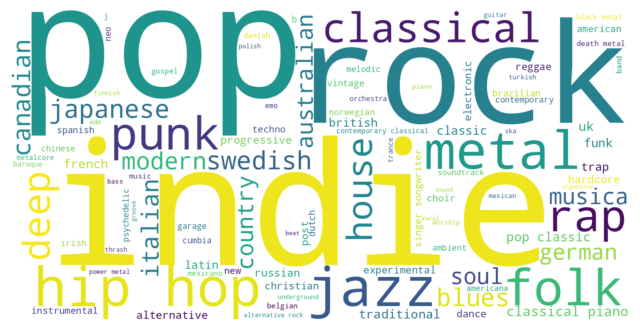

In [32]:
from wordcloud import WordCloud

genres=genre_data['genres'].to_list()
text=' '.join(genres)

wordcloud = WordCloud(width=1600, height=800,min_font_size=10, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

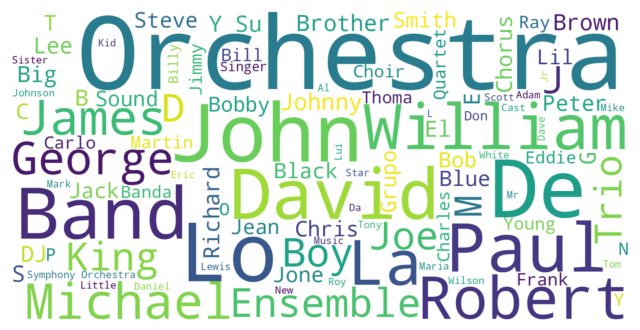

In [33]:
# word cloud of the artists

artists=' '.join(artist_data['artists'].to_list())

wordcloud = WordCloud(width=1600, height=800,min_font_size=10, max_words=100, background_color="white").generate(artists)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [34]:
top_10_artists=artist_data[['popularity','artists']].sort_values(by='popularity',ascending=False).head(10)
top_10_artists

,popularity,artists
20966,93.0,Ritt Momney
14354,92.0,Lele Pons
15070,90.0,Los Legendarios
11764,89.0,Jerry Di
28263,88.0,salem ilese
7463,88.0,Emilee
23687,88.0,Surf Mesa
213,87.0,A7S
14378,86.0,Lenny Santos
26318,86.0,Towy


# Phase 3 : Clustering Phase

In [35]:
genre_data.head()

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7


### Clustering Genres and Visualization (W/O genre)
We try here to see if the genres are clustered without the model knowing about them

In [36]:
# Applying K-Means on genre with n=12 clusters

OHE_features=['key','mode']

scaler_features=['mode', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'popularity']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False), OHE_features),
        ('scaler', StandardScaler(),scaler_features),
       ])


pipeline_without_genre=Pipeline(
    [('scaler',StandardScaler()),
     ('kmeans',KMeans(n_clusters=12,random_state=42))]
    )

pipeline_without_genre.fit(genre_data.drop('genres',axis=1))

clusters_without_genre=pipeline_without_genre.predict(genre_data.drop('genres',axis=1))

/home/mszeghdar/.pyenv/versions/3.10.12/envs/.colab/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [37]:
# Using TSNE to visualize the clusters
tsne=Pipeline(
    [
    ('preprocessor',preprocessor),
     ('tsne',TSNE(n_components=2,
                  random_state=42,
                  perplexity=30,
                  early_exaggeration=12
                  ))
     ]
    )

genre_reduced_without_genre=tsne.fit_transform(genre_data.drop('genres',axis=1))
genre_reduced_without_genre_df=pd.DataFrame(genre_reduced_without_genre,columns=['x1','x2'])
genre_reduced_without_genre_df['cluster']=clusters_without_genre
genre_reduced_without_genre_df['genres']=genre_data['genres']

/home/mszeghdar/.pyenv/versions/3.10.12/envs/.colab/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [38]:
fig = px.scatter(
    genre_reduced_without_genre_df,
    x='x1',
    y='x2',
    color='cluster',
    hover_data=['genres'],
    title='Scatter Plot of x1 vs x2',
    labels={'x1': 'Feature X1', 'x2': 'Feature X2', 'cluster': 'Cluster'},
    color_continuous_scale=px.colors.qualitative.Plotly
)

fig.update_traces(
    hovertemplate="<br>".join([
        "X1: %{x}",
        "X2: %{y}",
        "Genre: %{customdata[0]}",
        "Cluster: %{marker.color}"
    ])
)

fig.show()

### Clustering Genres and Visualization (With genre OHE)

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False), OHE_features+['genres']),
        ('scaler', StandardScaler(),scaler_features),
       ])

pipeline_genre_ohe=Pipeline(
    [('preprocessor',preprocessor),
    ('kmeans',KMeans(n_clusters=12,random_state=42))]
    )

pipeline_genre_ohe.fit(genre_data)
clusters=pipeline_genre_ohe.predict(genre_data)

/home/mszeghdar/.pyenv/versions/3.10.12/envs/.colab/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

/home/mszeghdar/.pyenv/versions/3.10.12/envs/.colab/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [40]:
tsne_ohe=Pipeline([
    ('preprocessor',preprocessor),
    ('tsne',TSNE(n_components=2,
                  random_state=42,
                  perplexity=30,
                  early_exaggeration=12
                  ))
            ])

genre_clustered_ohe=pd.DataFrame(tsne_ohe.fit_transform(genre_data),columns=['x','y'])
genre_clustered_ohe['cluster']=clusters
genre_clustered_ohe['genres']=genre_data['genres']

fig = px.scatter(
    genre_clustered_ohe,
    x='x',
    y='y',
    color='cluster',
    hover_data=['genres'],
    title='Scatter Plot of x1 vs x2',
    labels={'x1': 'Feature X1', 'x2': 'Feature X2', 'cluster': 'Cluster'},
    color_continuous_scale=px.colors.qualitative.Plotly
)

fig.update_traces(
    hovertemplate="<br>".join([
        "X1: %{x}",
        "X2: %{y}",
        "Genre: %{customdata[0]}",
        "Cluster: %{marker.color}"
    ])
)

fig.show()

/home/mszeghdar/.pyenv/versions/3.10.12/envs/.colab/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



### Clustering Songs and Visualization

In [41]:
# Loaded the dataset for clustering and visualization purpose only
track_data_raw=pd.read_csv("./data/data.csv")
track_data_raw.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [42]:
columns = ['valence','year' ,'acousticness', 'danceability', 'duration_ms', 'energy', 
                     'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 
                     'popularity', 'speechiness', 'tempo']
X = track_data_raw[columns]

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
kmeans = KMeans(n_clusters=25, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

/home/mszeghdar/.pyenv/versions/3.10.12/envs/.colab/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



# Phase 4 : Modeling (Recommendation System)

In [47]:
track_data.head(2)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,artists_v1,artists_v2,genres_v1,genres_v2,decade
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,0.0366,80.954,"[Sergei Rachmaninoff, James Levine, Berliner P...","[Sergei_Rachmaninoff, James_Levine, Berliner_P...","[classical, orchestral performance, ukrainian ...","[german_orchestra, classical, orchestra, opera...",1920
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,0.4150,60.936,[Dennis Day],[Dennis_Day],[],[],1920


In [19]:
def preprocess_genres(df):
    def process_genre(genre):
        if isinstance(genre, str):
            return eval(genre)
        return genre

    all_genres = df['genres'].apply(process_genre)
    
    flattened_genres = [genre for sublist in all_genres for genre in sublist]
    
    genre_string = ' '.join(flattened_genres)
    
    tfidf = TfidfVectorizer(max_features=1000)
    
    tfidf.fit([genre_string])
    
    genre_tfidf = tfidf.transform(all_genres.apply(' '.join))
    
    genre_tfidf_df = pd.DataFrame(genre_tfidf.toarray(), columns=tfidf.get_feature_names_out(), index=df.index)
    
    df = df.drop('genres', axis=1)
    df = pd.concat([df, genre_tfidf_df], axis=1)
    
    return df


preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=True), ['decade', 'popularity']),
    ('minmax', MinMaxScaler(), ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo'])
], sparse_threshold=0.8, n_jobs=-1)

def prepare_data(track_data):
    '''
        This functions prepares the raw dataset.
        Parameters: 
            track_data (Pandas Dataframe): Music tracks dataset
    '''

    features = ['valence', 'year', 'acousticness', 'danceability', 'energy', 'instrumentalness', 
                'liveness', 'loudness', 'popularity', 'speechiness', 'tempo', 'genres_v2', 'id']

    dataset = track_data[features].copy()
    dataset = dataset.rename({'genres_v2': 'genres'}, axis=1)
    dataset['popularity'] = dataset['popularity'].apply(lambda x: x // 5)
    dataset['decade']=dataset['year'].apply(lambda x: (x//10)*10)
    dataset.drop(['popularity','year'],axis=1)
    return dataset

def preprocess_data(dataset):
    X = preprocessor.fit_transform(dataset.drop('id', axis=1))
    return X

def build_nearest_neighbors(preprocessed_data, n_neighbors=21):  
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute', n_jobs=-1)
    nn.fit(preprocessed_data)
    return nn

def get_recommendations(nn_model, dataset, preprocessed_data, seed_song_id, n_recommendations=20):
    seed_index = dataset[dataset['id'] == seed_song_id].index[0]

   
    distances, indices = nn_model.kneighbors(preprocessed_data[seed_index], n_neighbors=n_recommendations + 1) #n_neighbors=n_recommendations + 1, the +1 to account the song itself

    recommended_songs = []
    for i, idx in enumerate(indices[0][1:], 1):  # Skip the first one as it is the seed song itself
        song = dataset.iloc[idx]
        recommended_songs.append({
            'id': song['id'],
            'similarity_score': 1 - distances[0][i],  # Convert distance to similarity
            'year': song['year'],
            'genres': song['genres'],
            'popularity': song['popularity'] * 5  # Convert back to original scale
        })
    return recommended_songs

prepared_data = prepare_data(track_data)
tfidf_data=preprocess_genres(prepared_data)
preprocessed_data = preprocess_data(tfidf_data)
nn_model = build_nearest_neighbors(preprocessed_data)

/home/mszeghdar/.pyenv/versions/3.10.12/envs/.colab/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
def get_recommendations_table(seed_song_id, n_recommendations=10):

    recommendations = get_recommendations(nn_model, prepared_data, preprocessed_data, seed_song_id, n_recommendations)

    table_data = [[i, track_data[track_data['id'] == song['id']]['name'].values[0],
                   track_data[track_data['id'] == song['id']]['artists'].values[0],
                   song['year'], song['popularity'], song['genres'], f"{song['similarity_score']:.4f}"]
                  for i, song in enumerate(recommendations, 1)]
    
    return tabulate(table_data, ["#", "Name", "Artist", "Year", "Popularity", "Genres", "Similarity"], tablefmt="grid")

In [14]:
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

def display_tracks_info(input_track_id):
    input_track = sp.track(input_track_id)
    
    recommendations = get_recommendations(nn_model, prepared_data, preprocessed_data, input_track_id, 20)
    recommended_track_ids = [track['id'] for track in recommendations]

    tracks_html = """
    <div style='font-family: Arial, sans-serif; background-color: #121212; padding: 20px;'>
        <h2 style='color: #ffffff; text-align: center; margin-bottom: 20px;'>Input Song</h2>
    """
    
    tracks_html += create_track_html(input_track, is_input=True)
    
    tracks_html += """
        <h2 style='color: #ffffff; text-align: center; margin: 30px 0 20px;'>Recommendations</h2>
        <hr style='border: 0; height: 1px; background-image: linear-gradient(to right, rgba(255, 255, 255, 0), rgba(255, 255, 255, 0.75), rgba(255, 255, 255, 0));'>
    """
    
    for track_id in recommended_track_ids:
        track = sp.track(track_id)
        tracks_html += create_track_html(track)
    
    tracks_html += "</div>"
    display(HTML(tracks_html))

def create_track_html(track, is_input=False):
    song_name = track['name']
    artist_id = track['artists'][0]['id']
    artist_name = track['artists'][0]['name']
    album_name = track['album']['name']
    release_year = track['album']['release_date'][:4]
    album_cover_url = track['album']['images'][0]['url']
    
    artist_info = sp.artist(artist_id)
    genres = ', '.join(artist_info['genres'][:3]) if artist_info['genres'] else 'Not specified'
    
    border_style = "border: 2px solid #1DB954;" if is_input else ""
    
    return f"""
    <div style='display: flex; align-items: center; margin-bottom: 20px; background-color: #181818; border-radius: 8px; overflow: hidden; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); {border_style}'>
        <img src="{album_cover_url}" style='width: 120px; height: 120px; object-fit: cover;'>
        <div style='padding: 15px; flex-grow: 1;'>
            <h3 style='margin: 0; color: #ffffff; font-size: 18px;'>{song_name}</h3>
            <p style='margin: 8px 0; color: #b3b3b3; font-size: 14px;'>
                <span style='color: #1DB954;'>Artist:</span> {artist_name}<br>
                <span style='color: #1DB954;'>Album:</span> {album_name}<br>
                <span style='color: #1DB954;'>Year:</span> {release_year}<br>
                <span style='color: #1DB954;'>Genres:</span> {genres}
            </p>
        </div>
    </div>
    """

In [21]:
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

display_tracks_info('6xXlurslWqFuyqTCBlErzX')